In [1]:
from models.imagenet import mobilenetv2
from  models.imagenet.mbnetv2 import mbnetv2
import torch
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import torch.nn.functional as F


In [2]:

# net = mobilenetv2()
# net.load_state_dict(torch.load('pretrained/mobilenetv2-c5e733a8.pth'))

In [3]:
mnet = mbnetv2()

Initializing weights...


In [4]:
mnet

MobileNetV2(
  (first_conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (bottleneck_sequential_blocks): ModuleList(
    (0): Sequential(
      (0): InvertedResidual(
        (conv): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
          (3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
    (1): Sequential(
      (0): InvertedResidual(
        (conv): Sequential(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, 

In [8]:
cfgs = [
            [1,  16, 1, 1],
            [6,  24, 2, 2],
            [6,  32, 3, 2],
            [6,  64, 4, 2],
            
            [6,  96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]
cfgs = [cfg[2] for cfg in cfgs]

In [9]:
type(cfgs)

list

In [10]:
def convert_state_dict(pretrained_sd,cfgs):
    new_sd = {}
    for k, v in pretrained_sd.items():
        # print(f"Converting {k} to ")
        # print(v)
        # First layer mapping
        if k.startswith('features.0'):
            new_key = k.replace('features.0', 'first_conv')
            new_sd[new_key] = v
        # Bottleneck blocks mapping (may need to adjust for all indices)
        elif k.startswith('features'):
            parts = k.split('.')
            block_idx = int(parts[1]) - 1      # because features.0 is first_conv
            # Find the corresponding config
            idx_1 = 0
            idx_2 = 0
            for i, cfg in enumerate(cfgs):
                if sum(cfgs[:i+1]) > block_idx:
                    idx_1 = i
                    idx_2 = block_idx - sum(cfgs[:i])
                    break

            rest = '.'.join(parts[2:])
            new_key = f'bottleneck_sequential_blocks.{idx_1}.{idx_2}.{rest}'
            new_sd[new_key] = v
        # Last layers mapping (if present)
        elif k.startswith('conv'):
            new_sd[k] = v
        elif k.startswith('classifier'):
            new_sd[k] = v
        else:
            # Handle or ignore unexpected keys
            pass
    return new_sd

In [11]:
pretrained_sd = torch.load('pretrained/mobilenetv2-c5e733a8.pth')
converted_sd = convert_state_dict(pretrained_sd, cfgs)
mnet.load_state_dict(converted_sd)


/tmp/ipykernel_145198/1816708528.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_sd = torch.load('pretrained/mobilenetv2-c5e733a8.pth')


<All keys matched successfully>

In [12]:
pretrained_sd

OrderedDict([('features.0.0.weight',
              tensor([[[[ 2.1846e-02, -8.7668e-02,  1.0513e-01],
                        [-1.4429e-01, -4.7979e-02,  1.6453e-01],
                        [ 1.3048e-01,  2.1146e-01,  2.6247e-01]],
              
                       [[ 1.1454e-02, -2.1475e-02,  1.4423e-01],
                        [-1.2300e-01,  6.9189e-02,  2.7332e-01],
                        [ 1.8005e-01,  3.6964e-01,  4.1340e-01]],
              
                       [[-9.0950e-02, -1.7083e-01, -6.2502e-02],
                        [-1.4637e-01,  6.8925e-04,  1.5432e-01],
                        [ 1.2582e-01,  2.7828e-01,  3.2760e-01]]],
              
              
                      [[[-2.9084e-08, -2.3159e-08, -1.7805e-08],
                        [-5.6065e-08, -4.8129e-08, -4.0961e-08],
                        [-5.3092e-08, -4.5576e-08, -3.8390e-08]],
              
                       [[ 4.2543e-08,  4.9921e-08,  5.3763e-08],
                        [ 3.3074e-08, 

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)

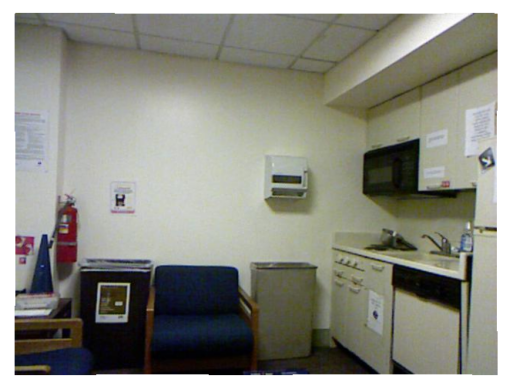

(tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.1095,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 

In [14]:

# Load image
img_path = '../nyu_data/data/nyu2_test/00000_colors.png'
img = Image.open(img_path).convert('RGB')

# Display the image
plt.imshow(img)
plt.axis('off')
plt.show()

# Define transforms matching training input requirements
input_size = 224  # or your chosen input size
transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor() #,
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet means
                        #  std=[0.229, 0.224, 0.225])   # ImageNet stds
])

# Apply transforms
img_tensor = transform(img).unsqueeze(0)  # add batch dimension

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
img_tensor = img_tensor.to(device)


mnet.eval()
mnet = mnet.to(device)
# Forward pass
with torch.no_grad():
  output = mnet(img_tensor)

print(output)  # raw model outputs (logits)


In [15]:
for i in range(len(output[1])):
    print(f"{i+1}th bottleneck output: {output[1][i].size()}")

1th bottleneck output: torch.Size([1, 16, 112, 112])
2th bottleneck output: torch.Size([1, 24, 56, 56])
3th bottleneck output: torch.Size([1, 32, 28, 28])
4th bottleneck output: torch.Size([1, 64, 14, 14])
5th bottleneck output: torch.Size([1, 96, 14, 14])
6th bottleneck output: torch.Size([1, 160, 7, 7])
7th bottleneck output: torch.Size([1, 320, 7, 7])


In [25]:

def conv_3x3_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        assert stride in [1, 2]

        hidden_dim = round(inp * expand_ratio)
        self.identity = stride == 1 and inp == oup

        if expand_ratio == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
    
    def forward(self, x):
        if self.identity:
            return x + self.conv(x)
        else:
            return self.conv(x)

In [26]:
output[0].shape

torch.Size([1, 1280, 7, 7])

In [27]:
class PixelShuffleX2(nn.Module):
    def __init__(self, upscale_factor=2):
        super().__init__()
        self.ps = nn.PixelShuffle(upscale_factor)

    def forward(self, x):
        x = self.ps(x)
        return x

In [28]:
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Decoder, self).__init__()
        pixel = PixelShuffleX2
        bottleneck = InvertedResidual

        self.layer1 = nn.Sequential(
            pixel(2),
            bottleneck(80, 24, stride=1, expand_ratio=1),
            bottleneck(24, 24, stride=1, expand_ratio=6),
            bottleneck(24, 24, stride=1, expand_ratio=6),
            bottleneck(24, 24, stride=1, expand_ratio=6)
        )
        self.depth_conv_1 = nn.Conv2d(24, 1,kernel_size=1,bias=False)
        self.segm_conv_1 = nn.Conv2d(24, 19, kernel_size=1,bias=False)

        self.layer2 = nn.Sequential(
            pixel(2),
            bottleneck(6, 16, stride=1, expand_ratio=3),
            bottleneck(16, 16, stride=1, expand_ratio=6),
            bottleneck(16, 16, stride=1, expand_ratio=6)
        )
        self.depth_conv_2 = nn.Conv2d(16, 1,kernel_size=1,bias=False)
        self.segm_conv_2 = nn.Conv2d(16, 19, kernel_size=1,bias=False)


        self.layer3 = nn.Sequential(
            pixel(2),
            bottleneck(4, 8, stride=1, expand_ratio=6),
            bottleneck(8, 8, stride=1, expand_ratio=6),
            bottleneck(8, 8, stride=1, expand_ratio=6)
        )
        self.depth_conv_3 = nn.Conv2d(8, 1,kernel_size=1,bias=False)
        self.segm_conv_3 = nn.Conv2d(8, 19, kernel_size=1,bias=False)

        self.layer4 = nn.Sequential(
            pixel(2),
                bottleneck(2, 8, stride=1, expand_ratio=6),
                bottleneck(8, 8, stride=1, expand_ratio=6)
        )
        self.depth_conv_4 = nn.Conv2d(8, 1,kernel_size=1,bias=False)
        self.segm_conv_4 = nn.Conv2d(8, 19, kernel_size=1,bias=False)

    def forward(self, x):
        depth_imgs=[]
        segm_imgs=[]
        out1 = self.layer1(x)
        depth_imgs.append(self.depth_conv_1(out1))
        segm_imgs.append(F.softmax(self.segm_conv_1(out1), dim=1))

        out2 = self.layer2(out1)
        depth_imgs.append(self.depth_conv_2(out2))
        segm_imgs.append(F.softmax(self.segm_conv_2(out2), dim=1))

        out3 = self.layer3(out2)
        depth_imgs.append(self.depth_conv_3(out3))
        segm_imgs.append(F.softmax(self.segm_conv_3(out3), dim=1))

        out4 = self.layer4(out3)
        depth_imgs.append(self.depth_conv_4(out4))
        segm_imgs.append(F.softmax(self.segm_conv_4(out4), dim=1))

        return depth_imgs, segm_imgs, out4

In [31]:
Decoder_block = Decoder(in_channels=320,out_channels=8)
Decoder_block.to(device)

Decoder(
  (layer1): Sequential(
    (0): PixelShuffleX2(
      (ps): PixelShuffle(upscale_factor=2)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=80, bias=False)
        (1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3): Conv2d(80, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2d(24, 144, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
        (3): Conv2d(144, 144, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=144, bias=False)
        (4): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, t

In [32]:
output = Decoder_block(output[1][6])

In [37]:
output[0][3].shape

torch.Size([1, 1, 112, 112])

In [38]:
def depth_to_display(depth_1x1HW: torch.Tensor, cmap='inferno'):
    # depth_1x1HW: (1,1,H,W)
    d = depth_1x1HW.detach().cpu().float().squeeze(0).squeeze(0)   # (H,W)
    # remove NaN/Inf and clip robustly using percentiles
    a = d.numpy()
    a = np.nan_to_num(a, nan=0.0, posinf=0.0, neginf=0.0)
    # robust range (ignore outliers)
    vmin, vmax = np.percentile(a, 2), np.percentile(a, 98)
    if vmax <= vmin:
        vmin, vmax = float(a.min()), float(a.max())
    a = np.clip(a, vmin, vmax)
    norm = (a - vmin) / (vmax - vmin + 1e-12)

    # grayscale uint8 for saving
    gray_u8 = (norm * 255).astype(np.uint8)

    # optional colored visualization
    plt.figure(figsize=(4,4))
    plt.imshow(norm, cmap=cmap)  # e.g., 'inferno', 'magma', 'turbo', 'viridis'
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return gray_u8  # HxW uint8


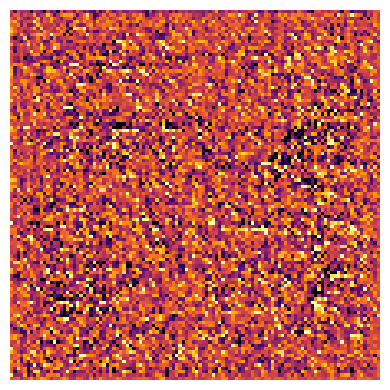

array([[135,  56, 147, ..., 121, 156, 159],
       [116, 165, 161, ..., 101, 169, 134],
       [160, 120, 180, ..., 156, 170, 137],
       ...,
       [160,  24, 122, ..., 145, 143, 161],
       [245,  97, 102, ..., 114, 140, 173],
       [147, 157, 167, ..., 155, 136, 144]], shape=(112, 112), dtype=uint8)

In [39]:
depth_to_display(output[0][3])  # (1,1,H,W)

### LOSS FUNCTIONS
